# Proyecto de Random Forest

In [71]:
# Importaciones necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn import tree
import joblib

## Paso 1: Cargar del conjunto de datos

In [68]:
# Cargar los datasets de entrenamiento y testeo analizados en el proyecto anterior
with open('../data/processed/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('../data/processed/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [69]:
# Valido la tamaño de los dataframes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 6)
(154, 6)
(614,)
(154,)


## Paso 2: Construir un random forest

### Modelo random forest

In [52]:
# Inicializcion y entrenamiento del modelo
model = RandomForestClassifier(n_estimators=100,  max_depth=20, min_samples_leaf=2,  random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=42)

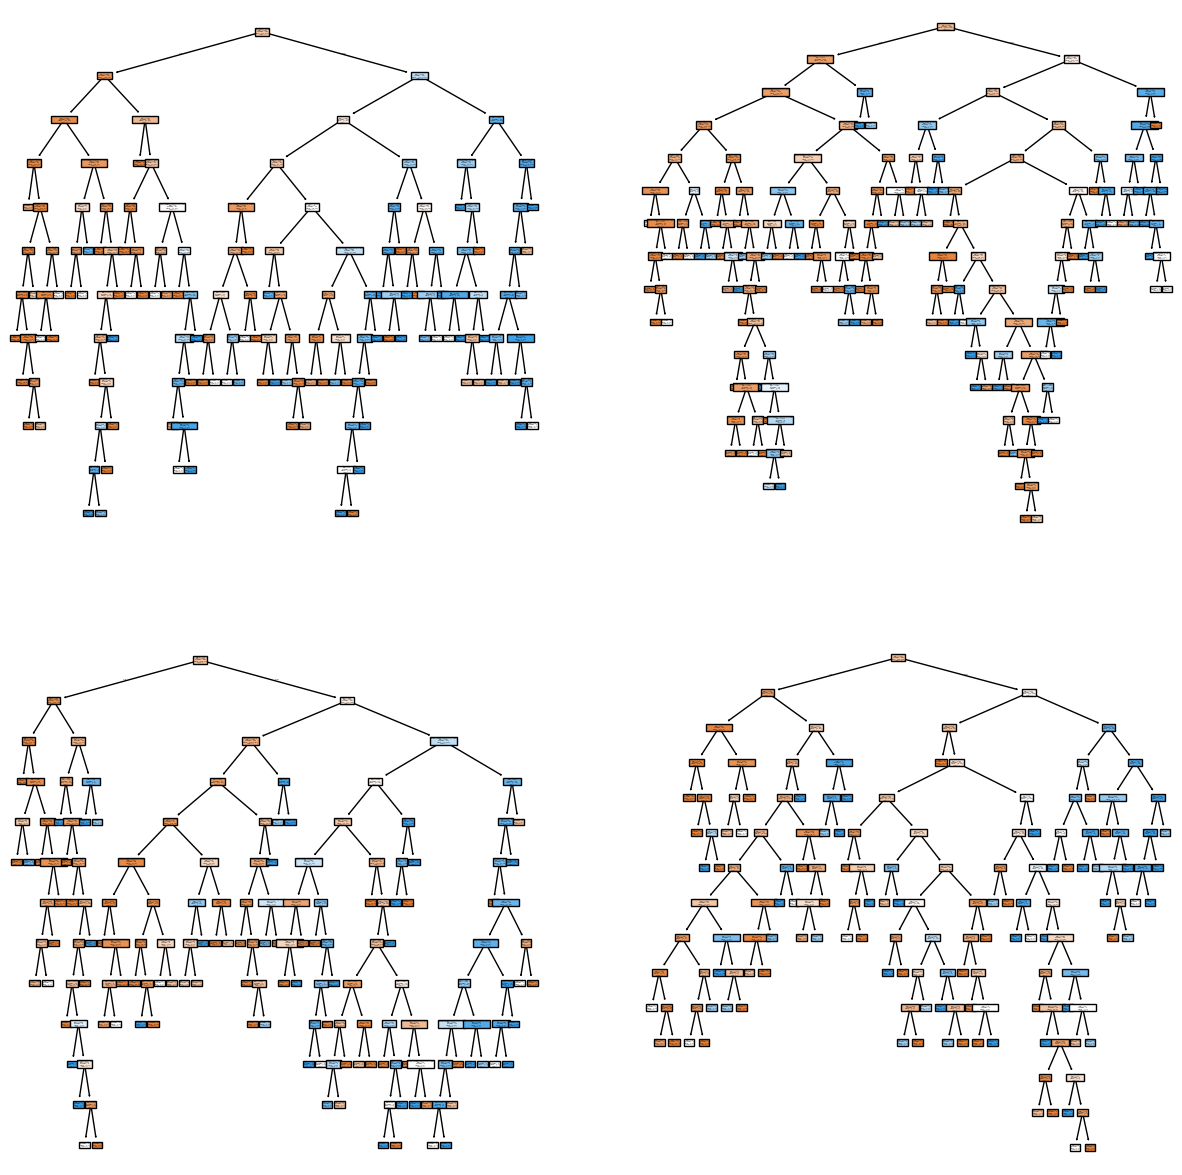

In [53]:
# Mostramos los 4 primeros arboles
fig, axis = plt.subplots(2, 2, figsize = (15, 15))

tree.plot_tree(model.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

In [54]:
#Una vez entrenado el modelo, se puede utilizar para realizar predicciones con el conjunto de datos
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [55]:
# Validacion de metricas
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [56]:
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.975570,0.964029,0.968090,0.985294,0.943662,0.992519
Test,0.772727,0.690265,0.758586,0.672414,0.709091,0.808081
Diferencia,0.202843,0.273763,0.209504,0.312880,0.234571,0.184438


Analisis: Se nota una mejora frente a los modelos de arbol de de decision simple y complejo estandar en la exactitud que es la metrica objetivo en este ejercicio (simple exactitud test = 	0.740260, complejo exactitud test = 0.746753), podria posiblemente mejorarse con hiperparametros calculados, vamos a validarlo.

### Optimizacion de hiperparametros

In [57]:
# Definimos el algoritmo base 
estimador = LGBMClassifier(force_col_wise=True)

# Definimos el espacio de búsqueda
hp_dict = {'n_estimators': [5, 50, 100],
           'max_depth': [20, 30, 40],
           'min_child_samples': [30, 40, 50, 60]}

# Busqueda random
# Definimos el como queremos buscar centrandonos en el accuracy, como lo pide las instrucciones
random_search = RandomizedSearchCV(estimador, hp_dict, n_iter = 10, scoring ='accuracy', cv = 5, random_state = 42, n_jobs = -1, verbose = 3)

In [58]:
# Iniciamos la búsqueda
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 170, number of negative: 321
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346232 -> initscore=-0.635643
[LightGBM] [Info] Start training from score -0.635643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(force_col_wise=True),
                   n_jobs=-1,
                   param_distributions={'max_depth': [20, 30, 40],
                                        'min_child_samples': [30, 40, 50, 60],
                                        'n_estimators': [5, 50, 100]},
                   random_state=42, scoring='accuracy', verbose=3)

In [59]:
random_search.best_params_

{'n_estimators': 50, 'min_child_samples': 50, 'max_depth': 40}

In [60]:
# Busqueda exhaustiva
# Definimos el algoritmo base

estimador = LGBMClassifier(force_col_wise=True)

# Definimos el espacio de búsqueda
hp_dict_1 = {'n_estimators': [30, 50, 70],
           'max_depth': [20, 30, 40, 50],
           'min_child_samples': [30, 40, 50, 60]}

grid_search = GridSearchCV(estimador, hp_dict_1, scoring='accuracy', cv = 5, n_jobs = -1, verbose = 3)

In [61]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[CV 2/5] END max_depth=20, min_child_samples=50, n_estimators=50;, score=0.813 total time=   0.0s
[CV 5/5] END max_depth=20, min_child_samples=40, n_estimators=70;, score=0.770 total time=   0.0s
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

GridSearchCV(cv=5, estimator=LGBMClassifier(force_col_wise=True), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40, 50],
                         'min_child_samples': [30, 40, 50, 60],
                         'n_estimators': [30, 50, 70]},
             scoring='accuracy', verbose=3)

In [62]:
grid_search.best_params_

{'max_depth': 20, 'min_child_samples': 50, 'n_estimators': 50}

In [63]:
# Nuevo modelo random con hiperparametros mejorados
modelo2 = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=50, random_state=42)
modelo2.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=50, n_estimators=50,
                       random_state=42)

In [64]:
#Una vez entrenado el modelo 2, se puede utilizar para realizar predicciones con el conjunto de datos
y_test_pred2 = modelo2.predict(X_test)
y_train_pred2 = modelo2.predict(X_train)

### Comparación de métricas

In [65]:
# Nuevas metricas, para el modelo 2
get_metrics(y_train, y_test, y_train_pred2, y_test_pred2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.778502,0.611429,0.713767,0.781022,0.502347,0.925187
Test,0.772727,0.646465,0.730303,0.727273,0.581818,0.878788
Diferencia,0.005774,-0.035036,-0.016536,0.053749,-0.079471,0.046399


In [66]:
# Metricas anteriores para comparar
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.975570,0.964029,0.968090,0.985294,0.943662,0.992519
Test,0.772727,0.690265,0.758586,0.672414,0.709091,0.808081
Diferencia,0.202843,0.273763,0.209504,0.312880,0.234571,0.184438


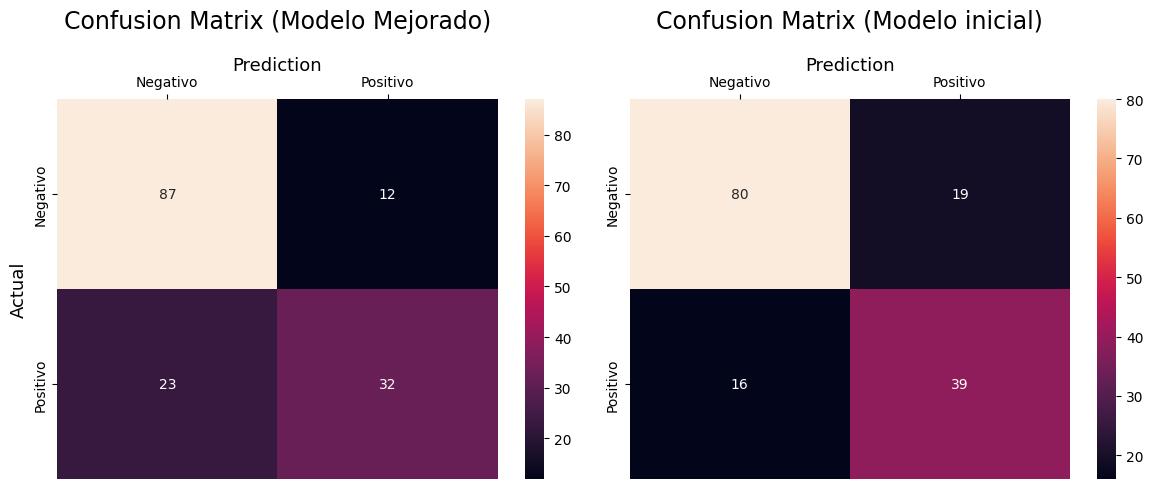

In [67]:
# Calcular las matrices de confusión para ambos modelos
cm_model = confusion_matrix(y_test, y_test_pred)  # Matriz de confusión del modelo
cm_modelo2 = confusion_matrix(y_test, y_test_pred2)    # Matriz de confusión del modelo2 mejorado

# Crear una figura con dos subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Matriz de confusión del modelo complejo (izquierda)
sns.heatmap(cm_modelo2, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax1)
ax1.set_ylabel('Actual', fontsize=13)
ax1.set_title('Confusion Matrix (Modelo Mejorado)', fontsize=17, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Prediction', fontsize=13)
ax1.xaxis.tick_top()

# Gráfico 2: Matriz de confusión del modelo simple (derecha)
sns.heatmap(cm_model, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax2)
ax2.set_title('Confusion Matrix (Modelo inicial)', fontsize=17, pad=20)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Prediction', fontsize=13)
ax2.xaxis.tick_top()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Analisis final: El modelo con los hiperparametros mejorados solo logra mejores metricas en precision y especificidad en los datos de prueba, la exactitud, F1, area bajo la curva y recall siguen siendo mejores en el modelo obtenido con los datos por defecto.

De la matriz de confusion se ve como aunque el modelo optimizado gana 7 predicciones negativas, pero en las predicciones positivas es mucho mejor el modelo sin optimizacion.

## Paso 3: Guardar el modelo

In [72]:
# Guardar los modelos
joblib.dump(modelo2, '../models/random_tree2_model.pkl')
joblib.dump(model, '../models/random_tree_model.pkl')

['../models/random_tree_model.pkl']